# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [152]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [235]:
data_train=data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks)]

In [236]:
data_train

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2193522,601,40879600955,614,62469,1,1.49,3102,0.00,1330,88,0.0,0.0
2193523,601,40879600955,614,65714,1,1.49,3102,0.00,1330,88,0.0,0.0
2193524,601,40879600955,614,111874,1,0.99,3102,-0.60,1330,88,0.0,0.0
2193525,601,40879600955,614,131818,1,1.39,3102,0.00,1330,88,0.0,0.0


In [153]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [154]:
recommender = MainRecommender(data_train_lvl_1)

In [155]:
recommender.get_als_recommendations(2500, N=5)

[859877, 1126899, 915586, 939681, 9420181]

In [209]:
recommender.get_own_recommendations(463 , N=5)

[1036093, 9553193, 5568758, 9553176, 5568606]

In [157]:
recommender.get_similar_items_recommendation(2500, N=5)

[1121808, 1034176, 6533362, 12301073, 6463742]

In [210]:
recommender.get_similar_users_recommendation(2500, N=5)

[863762, 1017739, 961730, 9803433, 918046]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [191]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']


In [192]:
result_lvl_1=result_lvl_1[result_lvl_1.user_id.isin(data_train_lvl_1.user_id.unique())]

In [193]:
result_lvl_1['similar_items']=result_lvl_1.user_id.apply(lambda x: recommender.get_similar_items_recommendation(x, N=50) )

In [194]:
result_lvl_1['als']=result_lvl_1.user_id.apply(lambda x: recommender.get_als_recommendations(x, N=50) )

In [195]:
result_lvl_1['own_recommendations']=result_lvl_1.user_id.apply(lambda x: recommender.get_own_recommendations(x, N=50) )

In [196]:
result_lvl_1

,user_id,actual,similar_items,als,own_recommendations
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1026448, 1007512, 9297615, 5577022, 10356272,...","[5577022, 883616, 1135195, 8090541, 5569376, 8...","[856942, 9297615, 5577022, 877391, 9655212, 88..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[916122, 5569230, 844179, 1004906, 1029743, 86...","[911974, 1076580, 1103898, 5567582, 1056620, 9..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[1099446, 861279, 872177, 999714, 821741, 9737...","[821741, 1091383, 6391541, 891423, 846502, 109...","[6391541, 1052294, 891423, 936470, 1137010, 11..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 819308, 941361, 1074754, 110...","[857006, 871611, 1084036, 965267, 1026118, 933...","[13003092, 972416, 995598, 923600, 1138596, 10..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[972931, 1044078, 5565612, 995478, 948468, 965...","[1100140, 1060408, 10285022, 945294, 959179, 1...","[998519, 894360, 7147142, 9338009, 896666, 939..."
...,...,...,...,...,...
2149,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16...","[985999, 5569845, 990797, 998239, 1044078, 100...","[844179, 1004906, 899624, 1044078, 916122, 806...","[872826, 983665, 991546, 1134296, 7441210, 974..."
2150,2497,"[820291, 824759, 838797, 859010, 859075, 86077...","[6534201, 865026, 8177622, 850102, 910473, 826...","[12810391, 957951, 1050741, 5569471, 963971, 8...","[870515, 1117219, 1102207, 1057168, 1135834, 1..."
2151,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15...","[1070820, 901062, 830503, 13008412, 1074516, 8...","[6513604, 916122, 830503, 8119004, 844179, 663...","[1022066, 1076580, 1100379, 5565356, 931579, 8..."
2152,2499,"[861282, 921744, 1050968, 13842089, 828837, 86...","[901062, 6534480, 907631, 1027642, 1004906, 10...","[5569230, 1029743, 907631, 5568378, 8090521, 1...","[7168055, 1128395, 6904613, 5570048, 889989, 8..."


In [199]:
result_lvl_1['als_recal']=result_lvl_1.apply(lambda x: recall_at_k(x.als, x.actual, k=50), axis=1)

In [200]:
print(f'ALS recal {result_lvl_1.als_recal.mean()}')

ALS recal 0.04745046042961292


In [201]:
result_lvl_1['similar_items_recal']=result_lvl_1.apply(lambda x: recall_at_k(x.similar_items, x.actual, k=50), axis=1)

In [202]:
print(f'Similar items recal {result_lvl_1.similar_items_recal.mean()}')

Similar items recal 0.03269785138270114


In [203]:
result_lvl_1['own_recommendations_recal']=result_lvl_1.apply(lambda x: recall_at_k(x.own_recommendations, x.actual, k=50), axis=1)

In [204]:
print(f'own_recommendations {result_lvl_1.own_recommendations_recal.mean()}')

own_recommendations 0.06525657038145175


#### own recommendtions + top-popular  дают лучший recall

In [211]:
result_lvl_1['own_recommendations_500']=result_lvl_1.user_id.apply(lambda x: recommender.get_own_recommendations(x, N=500) )

In [217]:
k_number = [20, 50, 100, 200, 500]
recal_list=[]

In [218]:
for k in k_number:
    result_lvl_1['recal']=result_lvl_1.apply(lambda x: recall_at_k(x.own_recommendations_500, x.actual, k=k), axis=1)
    recal=result_lvl_1.recal.mean() 
    recal_list.append(recal)

In [219]:
recal_list

[0.03928427679372909,
 0.06525657038145175,
 0.09604492955885034,
 0.13537278412833242,
 0.18205324555508678]

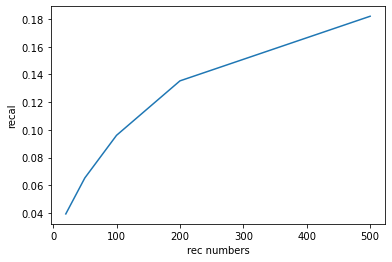

In [223]:
plt.plot(k_number, recal_list)
plt.xlabel('rec numbers')
plt.ylabel('recal')
plt.show()

С увеличением числа рекомендаций растет и полнота, что очевидно, так как у нас поялвется больше "попыток" попасть в реальную покупку. При этом, число рекомендаций необходимо выбирать исходя из бизнес логики. Нет смысла использовать для оценки модели recal@500, если рекомендовать к покупке мы будем только 20 товаров. 

In [375]:
result_lvl_1

,user_id,actual,similar_items,als,own_recommendations,als_recal,similar_items_recal,own_recommendations_recal,own_recommendations_500,recal
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1026448, 1007512, 9297615, 5577022, 10356272,...","[5577022, 883616, 1135195, 8090541, 5569376, 8...","[856942, 9297615, 5577022, 877391, 9655212, 88...",0.064220,0.036697,0.110092,"[856942, 9297615, 5577022, 877391, 9655212, 88...",0.302752
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090509, 5569845, 1044078, 985999, 880888, 81...","[916122, 5569230, 844179, 1004906, 1029743, 86...","[911974, 1076580, 1103898, 5567582, 1056620, 9...",0.054054,0.013514,0.013514,"[911974, 1076580, 1103898, 5567582, 1056620, 9...",0.189189
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[1099446, 861279, 872177, 999714, 821741, 9737...","[821741, 1091383, 6391541, 891423, 846502, 109...","[6391541, 1052294, 891423, 936470, 1137010, 11...",0.090909,0.090909,0.181818,"[6391541, 1052294, 891423, 936470, 1137010, 11...",0.227273
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[948650, 5569845, 819308, 941361, 1074754, 110...","[857006, 871611, 1084036, 965267, 1026118, 933...","[13003092, 972416, 995598, 923600, 1138596, 10...",0.037975,0.025316,0.075949,"[13003092, 972416, 995598, 923600, 1138596, 10...",0.202532
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[972931, 1044078, 5565612, 995478, 948468, 965...","[1100140, 1060408, 10285022, 945294, 959179, 1...","[998519, 894360, 7147142, 9338009, 896666, 939...",0.023256,0.000000,0.023256,"[998519, 894360, 7147142, 9338009, 896666, 939...",0.104651
...,...,...,...,...,...,...,...,...,...,...
2149,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16...","[985999, 5569845, 990797, 998239, 1044078, 100...","[844179, 1004906, 899624, 1044078, 916122, 806...","[872826, 983665, 991546, 1134296, 7441210, 974...",0.039370,0.055118,0.047244,"[872826, 983665, 991546, 1134296, 7441210, 974...",0.228346
2150,2497,"[820291, 824759, 838797, 859010, 859075, 86077...","[6534201, 865026, 8177622, 850102, 910473, 826...","[12810391, 957951, 1050741, 5569471, 963971, 8...","[870515, 1117219, 1102207, 1057168, 1135834, 1...",0.026846,0.013423,0.046980,"[870515, 1117219, 1102207, 1057168, 1135834, 1...",0.181208
2151,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15...","[1070820, 901062, 830503, 13008412, 1074516, 8...","[6513604, 916122, 830503, 8119004, 844179, 663...","[1022066, 1076580, 1100379, 5565356, 931579, 8...",0.017544,0.017544,0.017544,"[1022066, 1076580, 1100379, 5565356, 931579, 8...",0.087719
2152,2499,"[861282, 921744, 1050968, 13842089, 828837, 86...","[901062, 6534480, 907631, 1027642, 1004906, 10...","[5569230, 1029743, 907631, 5568378, 8090521, 1...","[7168055, 1128395, 6904613, 5570048, 889989, 8...",0.042254,0.028169,0.028169,"[7168055, 1128395, 6904613, 5570048, 889989, 8...",0.197183


### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [224]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))

In [228]:
users_lvl_2

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."
2,1753,"[967041, 963686, 948640, 1057168, 942475, 9421..."
3,2120,"[5707857, 1029743, 1106523, 5569230, 916122, 8..."
4,1346,"[1135983, 5569309, 1129982, 5574377, 5569993, ..."
...,...,...
2149,1446,"[6391134, 12487356, 827332, 7024847, 13007435,..."
2150,1784,"[917406, 1131625, 849578, 950935, 886395, 9796..."
2151,436,"[953180, 918046, 915459, 934399, 1092363, 8787..."
2152,1697,"[993838, 922847, 886103, 7442505, 13133916, 10..."


In [226]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [229]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [245]:
targets_lvl_2

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0
...,...,...,...
111308,1745,903454,0.0
111309,1745,9419888,0.0
111310,1745,1076769,0.0
111311,1745,1092588,0.0


In [233]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [ ]:
targets_lvl_2=targets_lvl_2.merge(item_features[['department', 'brand']])

In [237]:
data_train

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2193522,601,40879600955,614,62469,1,1.49,3102,0.00,1330,88,0.0,0.0
2193523,601,40879600955,614,65714,1,1.49,3102,0.00,1330,88,0.0,0.0
2193524,601,40879600955,614,111874,1,0.99,3102,-0.60,1330,88,0.0,0.0
2193525,601,40879600955,614,131818,1,1.39,3102,0.00,1330,88,0.0,0.0


#### Item features - цена и кол-во покупок в неделю

In [239]:
item_features_mined=data_train.groupby('item_id').sum()[['quantity', 'sales_value']]

In [241]:
item_features_mined['q_per_week']=item_features_mined['quantity']/88

In [243]:
item_features_mined['price']=item_features_mined['sales_value']/item_features_mined['quantity']

In [246]:
item_features_mined['item_id']=item_features_mined.index

In [248]:
targets_lvl_2=targets_lvl_2.merge(item_features_mined[['q_per_week', 'price']], on='item_id')

In [249]:
targets_lvl_2

,user_id,item_id,target,q_per_week,price
0,2070,1105426,0.0,1.272727,3.918839
1,1434,1105426,0.0,1.272727,3.918839
2,1174,1105426,0.0,1.272727,3.918839
3,1216,1105426,0.0,1.272727,3.918839
4,900,1105426,0.0,1.272727,3.918839
...,...,...,...,...,...
111308,1114,1090864,0.0,1.170455,2.166990
111309,170,1090864,0.0,1.170455,2.166990
111310,905,1011241,0.0,0.500000,5.110455
111311,2457,1011241,0.0,0.500000,5.110455


#### User features - cредний чек, частота покупок в месяц

In [277]:
user_features_mined=data_train.groupby('user_id').sum()[['quantity', 'sales_value']]

In [278]:
df=data_train.groupby(['user_id', 'day']).sum()

In [284]:
df['day_counter']=1

In [280]:
user_features_mined['mean_sheet']=df.groupby('user_id').mean()['sales_value']

In [288]:
user_features_mined['freq']=df.groupby('user_id').count().day_counter/22

In [291]:
user_features_mined['user_id']=user_features_mined.index
user_features_mined

,quantity,sales_value,mean_sheet,freq,user_id
user_id,,,,,
1,1689,3612.54,54.735455,3.000000,1
2,718,1728.67,41.158810,1.909091,2
3,8472,2554.98,59.418140,1.954545,3
4,358,1100.37,39.298929,1.272727,4
5,242,749.09,24.164194,1.409091,5
...,...,...,...,...,...
2496,120724,3898.51,88.602500,2.000000,2496
2497,2604,5947.91,35.616228,7.590909,2497
2498,31252,2348.11,18.784880,5.681818,2498


In [292]:
targets_lvl_2=targets_lvl_2.merge(user_features_mined[['mean_sheet', 'freq']], on='user_id')

In [293]:
targets_lvl_2

,user_id,item_id,target,q_per_week,price,mean_sheet,freq
0,2070,1105426,0.0,1.272727,3.918839,18.909117,12.863636
1,2070,1097350,0.0,0.602273,11.480566,18.909117,12.863636
2,2070,879194,0.0,0.613636,7.237222,18.909117,12.863636
3,2070,948640,0.0,0.556818,6.596122,18.909117,12.863636
4,2070,928263,0.0,0.625000,7.620727,18.909117,12.863636
...,...,...,...,...,...,...,...
111308,1550,912280,0.0,1.886364,2.505361,12.948387,7.045455
111309,1550,1021562,0.0,1.704545,2.239467,12.948387,7.045455
111310,1550,852014,0.0,1.806818,2.434906,12.948387,7.045455
111311,1550,5590613,0.0,4.454545,2.700332,12.948387,7.045455


#### user-item features : средняя цена айтема по категориям для каждого юзера

In [297]:
data_train=data_train.merge(item_features[['item_id','department']], on='item_id', how='left' )

In [311]:
data_train_1=data_train.copy()

In [318]:
df_dep=data_train_1.groupby(['user_id','department']).sum()

In [320]:
df_dep['mean_price']=df_dep['sales_value']/(df_dep['quantity']+1)

In [321]:
df_dep

basket_id     day     item_id  quantity  \
user_id department                                                    
1                        395606009647    4480    71743832         0   
        DELI            1719820593488   17600    88377585        53   
        DRUG GM         4373175040341   44502   538763346       161   
        FLORAL            32759995726     389     1051883         1   
        GROCERY        31680436511115  330457  3113175136      1120   
...                               ...     ...         ...       ...   
2500    NUTRITION        328840786056    4169    55534069        14   
        PASTRY           115389532440    1666    11014702         3   
        PRODUCE         2444491170379   27138   107119923        87   
        SEAFOOD          187991371528    1810    44874167         6   
        SEAFOOD-PCKGD     60967749463     497     2147854         2   

                       sales_value  store_id  retail_disc  trans_time  \
user_id department                                                      
1                             0.00      5232         0.00       16924   
        DELI                163.29     54073       -11.35       76521   
        DRUG GM             413.56    120790       -34.98      194016   
        FLORAL                7.99       436         0.00        1058   
        GROCERY            2323.41    576437      -468.67     1325542   
...                            ...       ...          ...         ...   
2500    NUTRITION            28.43      3783        -5.93       15541   
        PASTRY                2.90      1341        -1.98        3572   
        PRODUCE             162.26     30955       -26.37      124553   
        SEAFOOD              30.92      2682        -4.38       11002   
        SEAFOOD-PCKGD         3.00       894        -0.69        3848   

                       week_no  coupon_disc  coupon_match_disc  mean_price  
user_id department                                                          
1                          648        -7.25               0.00    0.000000  
        DELI              2548         0.00               0.00    3.023889  
        DRUG GM           6455       -11.34              -4.35    2.552840  
        FLORAL              56         0.00               0.00    3.995000  
        GROCERY          47892       -50.68             -14.00    2.072623  
...                        ...          ...                ...         ...  
2500    NUTRITION          602         0.00               0.00    1.895333  
        PASTRY             240         0.00               0.00    0.725000  
        PRODUCE           3930        -0.70              -0.70    1.843864  
        SEAFOOD            262         0.00               0.00    4.417143  
        SEAFOOD-PCKGD       72         0.00               0.00    1.000000  

[30997 rows x 12 columns]

In [324]:
user_mean_price_per_cat=pd.pivot_table(df_dep, index='user_id', columns='department', values='mean_price', fill_value=0 )

In [336]:
item_cat_dummies=pd.get_dummies(item_features[['item_id', 'department']])

In [339]:
item_cat_dummies.index=item_cat_dummies['item_id']
item_cat_dummies=item_cat_dummies.drop('item_id', axis=1)

In [352]:
targets_lvl_2['mean_cost_per_item_cat']=targets_lvl_2.apply(
    lambda x: np.dot
    (item_cat_dummies[item_cat_dummies.index==x.item_id].values[0],user_mean_price_per_cat[user_mean_price_per_cat.index==x.user_id].values[0]), axis=1)

In [389]:
targets_lvl_2[targets_lvl_2.user_id==3]

,user_id,item_id,target,q_per_week,price,mean_sheet,freq,mean_cost_per_item_cat,proba


#### обучение классификатора

In [354]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [360]:
X_train.iloc[:,2:]

,q_per_week,price,mean_sheet,freq,mean_cost_per_item_cat
0,1.272727,3.918839,18.909117,12.863636,3.292632
1,0.602273,11.480566,18.909117,12.863636,1.547688
2,0.613636,7.237222,18.909117,12.863636,2.727690
3,0.556818,6.596122,18.909117,12.863636,2.727690
4,0.625000,7.620727,18.909117,12.863636,2.727690
...,...,...,...,...,...
111308,1.886364,2.505361,12.948387,7.045455,1.597100
111309,1.704545,2.239467,12.948387,7.045455,1.130035
111310,1.806818,2.434906,12.948387,7.045455,1.130035
111311,4.454545,2.700332,12.948387,7.045455,1.130035


In [362]:
lgb = LGBMClassifier(objective='binary', max_depth=7 )
lgb.fit(X_train.iloc[:,2:], y_train)

train_preds = lgb.predict_proba(X_train.iloc[:,2:])

In [365]:
targets_lvl_2['proba']=train_preds[:,1]

In [384]:
targets_lvl_2[targets_lvl_2.user_id==1].sort_values('proba', ascending=False).item_id.unique()

array([  992986,  8090541,   856942,  5582712,  1104349,  5577022,
         911454,  9655212,  9296837,  8293439,  1131115,  7441419,
        1124029,   826695,  1121694,   898121,   983897,  9297615,
         979792,   995598,   888104,  8091601, 12352054, 12385374,
         991024,  1044487,   936685,   825123,  1082269, 10308345,
        9527558,  1087411,  6514011, 10457591,   985055,  9677939,
         962967,   849066,   835796,   933913,  7431134,   877391,
        1036852,  1088462, 12172170,   948640,  9803718,  7152319,
        1079484,   979674], dtype=int64)

In [376]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

In [392]:
result_lvl_2['lgb']=result_lvl_2.apply(lambda x: targets_lvl_2[targets_lvl_2.user_id==x.user_id].sort_values('proba', ascending=False).item_id.unique(), axis=1 )

<ipython-input-392-f41756e18fd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_lvl_2['lgb']=result_lvl_2.apply(lambda x: targets_lvl_2[targets_lvl_2.user_id==x.user_id].sort_values('proba', ascending=False).item_id.unique(), axis=1 )


In [393]:
result_lvl_2=result_lvl_2[result_lvl_2.user_id.isin(targets_lvl_2.user_id)]

In [405]:
result_lvl_2['recal']=result_lvl_2.apply(lambda x: recall_at_k(x.lgb, x.actual, k=20), axis=1)

In [406]:
result_lvl_2.recal.mean()

0.04087602467598482

Recal получился чуть выше, чем recal при k=20 у own reccomendation. 
У меня возник небольшой вопрос, нужна ваша помощь. 
Мы получаем кандидатов простым алгоритмом на трейн 1, на вал 1 мы формируем положительные и отрицательные пары из предсказаний простого алгоритма и обучаем классификатор. Вопрос вот в чем, каким образом делать предсказания для вал 2? У нас есть простая модель, которая подбирает кандидатов для вал 1, а не для вал 2. Ее нужно переобучать на трейн 1 и вал 1? Так же вопрос каким образом классификатор валидировать? На вал 1 или вал 2? Тут опять вопрос в том, что простая модель сгенерировала пары для вал 1 а не вал 2. В общем, немного запутался в финальной части, где непосредственно нужно сделать переранжирвоание сложным алгоритмом, как его валидировать не до конца понял. 

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 